In [1]:
%load_ext autoreload
%autoreload 2

from numcosmo_py import Ncm, Nc, GObject

from richness_mass_calib import create_richness_mass_calib
import numpy as np
import math
import sys
import os.path

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt

# Bibliotecas complementares
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA

#Settings
Ncm.cfg_init()

%matplotlib inline
sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy")

import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")

In [2]:
# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

#dt_halos['redshift_true','m200c', 'richness']

In [3]:
# catalog_cut = np.log(dt_halos['m200c']) < 31.0
# dt_halos = dt_halos[catalog_cut]

In [4]:
rmdata = create_richness_mass_calib(dt_halos)

use_ascaso = False

ascaso = Nc.ClusterMassAscaso()
ascaso.param_set_by_name("mup0", 4.45393539397061)
ascaso.param_set_by_name("mup1", 0.538092645909241)
ascaso.param_set_by_name("mup2", 0.931306629373459)
ascaso.param_set_by_name("sigmap0", 0.674689968522022)
ascaso.param_set_by_name("sigmap1", 0.0645030252979038)
ascaso.param_set_by_name("sigmap2", -0.244363116863723)
ascaso.param_set_by_name("cut", 6.0)

mset_ascaso = Ncm.MSet()
mset_ascaso.set(ascaso)

lnrich_ext = Nc.ClusterMassLnrichExt()
lnrich_ext.param_set_by_name("mu", 4.60456407051582)
lnrich_ext.param_set_by_name("muM1", 0.872079943089853)
lnrich_ext.param_set_by_name("muZ1", 1.77432682440775)
lnrich_ext.param_set_by_name("muM2", 0.0417736274804596)
lnrich_ext.param_set_by_name("muZ2", -0.140721577418961)
lnrich_ext.param_set_by_name("muMZ", 0.142254333837774)

lnrich_ext.param_set_by_name("sigma0", 0.288099083637692)
lnrich_ext.param_set_by_name("sigmaM1", 0.01665425603827)
lnrich_ext.param_set_by_name("sigmaZ1", -0.0170544925340452)
lnrich_ext.param_set_by_name("sigmaM2", 0.0151710348889877)
lnrich_ext.param_set_by_name("sigmaZ2", 0.00841242091702829)
lnrich_ext.param_set_by_name("sigmaMZ", 0.0375086602261856)

lnrich_ext.param_set_by_name("cut", 6.0)

mset_ext = Ncm.MSet()
mset_ext.set(lnrich_ext)

In [5]:
dset = Ncm.Dataset.new()
dset.append_data(rmdata)

lh = Ncm.Likelihood.new(dset)

mset_ascaso.param_set_all_ftype(Ncm.ParamType.FREE)
mset_ext.param_set_all_ftype(Ncm.ParamType.FREE)

fit_ascaso = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ascaso, Ncm.FitGradType.NUMDIFF_CENTRAL)

fit_ext = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ext, Ncm.FitGradType.NUMDIFF_CENTRAL)

fit_ascaso.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
fit_ext.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#...........................................................................................................................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:35.5059250
#  iteration            [001147]
#  function evaluations [001149]
#  gradient evaluations [000000]
#  degrees of freedom   [454468]
#  m2lnL     =     124008.811688488 (     124008.81 )
#  Fit parameters:
#     4.45402091028255     0.688649489346659    1.23734787828628     0.22716961526597    -0.0514106117960787  -0.125445421944678    5.66684849158643    
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 501931.610151631      
#  - r

In [6]:
lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

In [7]:
# lnR mean and std

def compute_res(rich_model):

    lnR_mean = np.array(
        [rich_model.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    lnR_std = np.array(
        [rich_model.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )

    abs_err = (lnR - lnR_mean) / lnR_std
    # Data cut
    sigma_cut = 5.0

    sigma_cut_array = np.abs(abs_err) < sigma_cut
    print(f"Cutting {sigma_cut}-sigma, {np.sum(np.logical_not(sigma_cut_array))}")

    lnR_mean = lnR_mean[sigma_cut_array]
    z_sigma_cut = z[sigma_cut_array]
    lnM_sigma_cut = lnM[sigma_cut_array]
    abs_err = abs_err[sigma_cut_array]
    
    return abs_err, lnR_mean, z_sigma_cut, lnM_sigma_cut



res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso = compute_res(ascaso)

res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext = compute_res(lnrich_ext)

np.savetxt('res_ext', res_ext) 

Cutting 5.0-sigma, 95
Cutting 5.0-sigma, 92


Text(0, 0.5, 'Residulas')

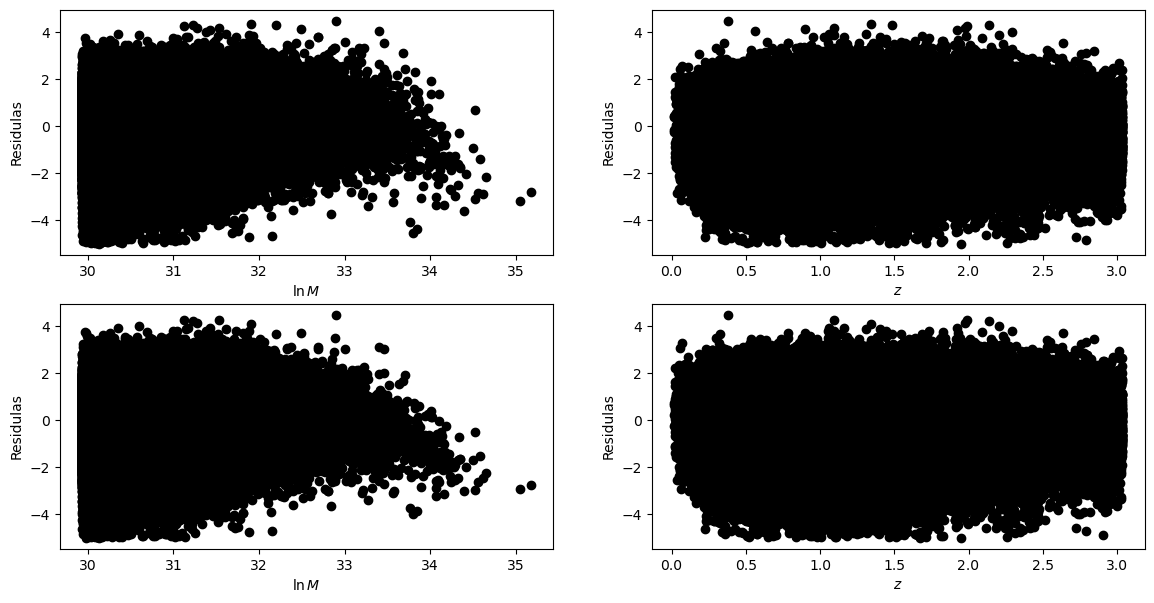

In [8]:
# Residuals

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.scatter(lnM_sigma_cut_ascaso, res_ascaso, c="k")
ax1.set_xlabel("$\ln M$")
ax1.set_ylabel("Residuals")

ax2.scatter(z_sigma_cut_ascaso, res_ascaso, c="k")
ax2.set_xlabel("$z$")
ax2.set_ylabel("Residuals")

ax3.scatter(lnM_sigma_cut_ext, res_ext, c="k")
ax3.set_xlabel("$\ln M$")
ax3.set_ylabel("Residuals")

ax4.scatter(z_sigma_cut_ext, res_ext, c="k")
ax4.set_xlabel("$z$")
ax4.set_ylabel("Residuals")


In [9]:
# lnM_array = np.linspace(min(lnM), max(lnM), 100)
# z_array = np.linspace(min(z), max(z), 100)

Text(0.5, 1.0, 'Residuals distribuition Ascaso')

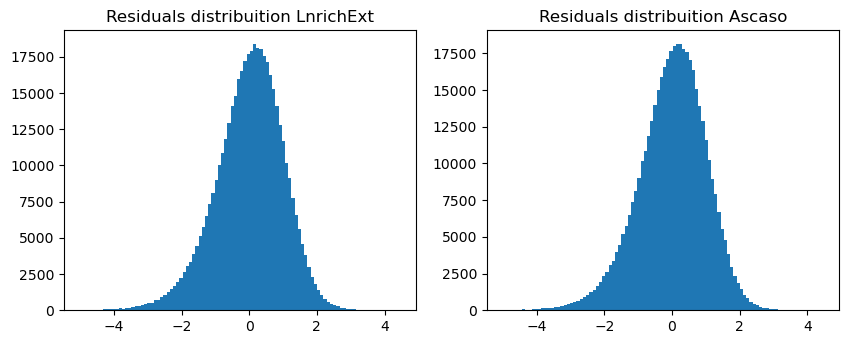

In [10]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax1.hist(res_ext, bins=100)
ax1.set_title("Residuals distribuition LnrichExt")

ax2.hist(res_ascaso, bins=100)
ax2.set_title("Residuals distribuition Ascaso")

In [11]:
print(f"{stats.skew(res_ext)} {stats.kurtosis(res_ext)}")

print(f"{stats.skew(res_ascaso)} {stats.kurtosis(res_ascaso)}")

-0.4624360405638134 0.6697171377271922
-0.4530903936413516 0.6506869855791035


NameError: name 'lnM_array' is not defined

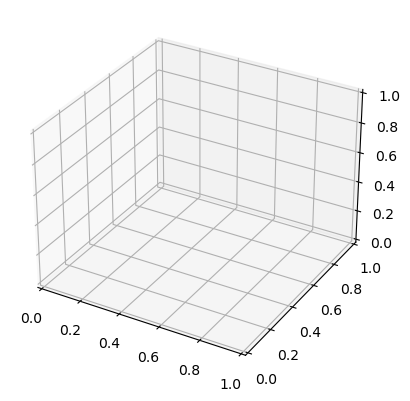

In [12]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X, Y = np.meshgrid(lnM_array, z_array)

Z = np.vectorize(ascaso.get_mean_richness)(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,
                       linewidth=0, antialiased=False)

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X, Y = np.meshgrid(lnM_array, z_array)

Z = np.vectorize(ascaso.get_std_richness)(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,
                       linewidth=0, antialiased=False)

In [ ]:
fit_ascaso.numdiff_m2lnL_covar()
fit_ext.numdiff_m2lnL_covar()

In [ ]:
cov_ascaso = np.square(fit_ascaso.get_covar().dup_array())
cov_ext = np.square(fit_ext.get_covar().dup_array())

dascaso = int(np.sqrt(len(cov_ascaso)))
cov_ascaso = cov_ascaso.reshape(dascaso, dascaso)

dext = int(np.sqrt(len(cov_ext)))
cov_ext = cov_ext.reshape(dext, dext)

In [ ]:
from numpy import linalg as lg

Eigenvalues, Eigenvectors = lg.eig(cov_ext)

print(Eigenvalues)
Eigenvectors[0]
Eigenvectors[1]
Eigenvectors[10]

In [ ]:
plt.hist(abs_err, bins=np.linspace(-5, 5, 100))
plt.title("Residuals distribuition")

In [ ]:
print(stats.shapiro(abs_err))
print(stats.kstest(abs_err, "norm"))

In [ ]:
print(f"mean {np.mean(abs_err)} std {np.std(abs_err)}")

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot()
# stats.probplot(abs_err, dist="norm", plot=ax)
# plt.show()

In [ ]:
plt.hist(z, bins=40)
plt.title("Redshift distribuition")

In [ ]:
z_sigma_cut_cut = np.logical_and(z_sigma_cut > 0.1, z_sigma_cut < 0.4)

In [ ]:
plt.hist(abs_err[z_sigma_cut_cut], bins=30)
plt.title("Residuals distribuition")

In [ ]:
plt.hist(lnM_sigma_cut, bins=40)
plt.title("Mass distribuition")

In [ ]:
print(f"{np.exp(min(lnM_sigma_cut)):e}")

In [ ]:
lnM_sigma_cut_cut = np.logical_and(lnM_sigma_cut > 31.0, lnM_sigma_cut < 31.2)

In [ ]:
plt.hist(abs_err[lnM_sigma_cut_cut], bins=30)
plt.title("Residuals distribuition")

In [ ]:
print(f"{stats.skew(abs_err)} {stats.kurtosis(abs_err)}")

In [ ]:
# MCMC
# Parameters posterior distribuition

# mcmc_fits = Table(fits.open('NumCosmo/MCMC_ascaso_test.fits')[1].data) #MCMC first results

dt_mcmc = list(Table(fits.open("MCMC_ascaso_test2.fits")[1].data))

df = pd.DataFrame(dt_mcmc)
df.columns = ["m2lnL", "mup0", "mup1", "mup2", "sigmap0", "sigmap1", "sigmap2"]

df_param = df[["mup0", "mup1", "mup2", "sigmap0", "sigmap1", "sigmap2"]]

In [ ]:
sns.set_theme(style="ticks", color_codes="r")
sns.pairplot(data=df_param, corner=True, diag_kind="kde")

In [ ]:
sns.jointplot(x=df_param["mup0"], y=df_param["mup1"], color="#4CB391")

In [ ]:
sns.jointplot(x=df_param["mup1"], y=df_param["mup2"], color="#E29578")

In [ ]:
sns.jointplot(x=df_param["sigmap0"], y=df_param["mup0"], color="#006D77")